In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, sys, json, pickle
import pandas as pd

In [103]:
result["track_box_index"].unique()

array([6867, 6873, 6879, 8217, 8223, 8269, 8275, 8281, 8283])

In [79]:


GRID_converter = {38:0, 19:1, 10:2, 5:3, 3:4, 1:5}
confidence_threshold = 0.6
mean_threshold = 0.6
mean_sample = 10



def identify_anchor_boundary(csv_flie_path):
    result = pd.read_csv(csv_flie_path)
    left, right = dict(), dict()
    for idx in result["track_box_index"].unique():

        data = result[result["track_box_index"]==idx].values[1:, :]
        n = data[:, 8] - 30
        prob = np.array([float(x.split("(")[1].split(",")[0]) for x in data[:,9]])
        n_sort = prob[n.argsort()]
        plt.plot(n_sort)
        plt.ylim(-0.1, 1.1)

        # 条件１；n=0でprocがthreshold(0.6)未満
        condition1 = (n_sort[29] < confidence_threshold)
        # 条件２；n=0から左右に数サンプル（10程度？）で，平均がmean_threshold以上の方向が存在する
        condition2 = np.array([(n_sort[29-mean_sample:29].mean() >= mean_threshold), (n_sort[30:30+mean_sample].mean() >= mean_threshold)])
        
        print("idx {}".format(idx))
        print("condition1 {}".format(condition1))
        print("condition2 {}".format(condition2))
        print("mean {:.3f} / {:.3f}".format(n_sort[29-mean_sample:29].mean(), n_sort[30:30+mean_sample].mean()))
        print()
        
        if condition1 and condition2[0]:
            left[idx] = data[0, 4:8].astype(np.int64)
        elif condition1 and condition2[1]:
            right[idx] = data[0, 4:8].astype(np.int64)
    return left, right


def compare_neighboring_anchors(left, right, factor):
    boundary = False
    for L in left:
        for R in right:
            if factor == "grid":
                if abs(left[L][-1] - right[R][-1]) == 1 and left[L][0] == right[R][0]:
                    boundary = True
            if factor == "scale":
                if abs(GRID_converter[left[L][0]] - GRID_converter[right[R][0]]) == 1:
                    boundary = True
    
    return boundary
    

idx 8323
condition1 True
condition2 [False False]
mean 0.031 / 0.003

idx 8325
condition1 True
condition2 [False False]
mean 0.029 / 0.002

idx 8329
condition1 True
condition2 [False False]
mean 0.370 / 0.428

idx 8331
condition1 True
condition2 [False False]
mean 0.201 / 0.299

idx 8335
condition1 True
condition2 [False False]
mean 0.011 / 0.077

idx 8389
condition1 True
condition2 [False False]
mean 0.315 / 0.280

idx 8395
condition1 True
condition2 [False False]
mean 0.002 / 0.026

{}
{}


False

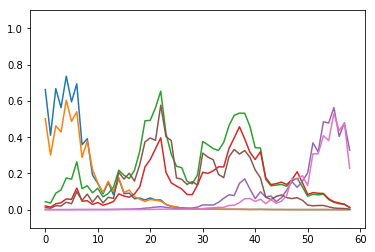

In [128]:
# file = "../detect_result/analyse_fragment/vgg16_basic_multilabel_thresh02/grid/bmx-bumps/000015/obj1/result_15.csv"
file = "../detect_result/analyse_fragment/vgg16_sigmoid_thresh_multilabel_thresh02/sw/0406/grid/bike-packing/000015/obj0/result_15.csv"

# file = "../detect_result/analyse_fragment/resnet50_std/multi-step_multilabel_thresh02/grid/parkour/000021/obj0/result_21.csv"

left, right = identify_anchor_boundary(file)
print(left)
print(right)
compare_neighboring_anchors(left, right, factor="grid")

In [132]:
def identify_anchor_boundary_wide(csv_flie_path):
    result = pd.read_csv(csv_flie_path)
    left, right = dict(), dict()
    for idx in result["track_box_index"].unique():

        data = result[result["track_box_index"]==idx].values[1:, :]
        n = data[:, 8] - 30
        prob = np.array([float(x.split("(")[1].split(",")[0]) for x in data[:,9]])
        n_sort = prob[n.argsort()]
        plt.plot(n_sort)
        plt.ylim(-0.1, 1.1)

        # 条件１；n=0でprocがthreshold(0.6)未満
        condition1 = (n_sort[29] < confidence_threshold)
#         # 条件２；n=0から左右に数サンプル（10程度？）で，平均がmean_threshold以上の方向が存在する
#         condition2 = np.array([(n_sort[29-mean_sample:29].mean() >= mean_threshold), (n_sort[30:30+mean_sample].mean() >= mean_threshold)])
        # 条件２．１：
        max_v, max_ind = n_sort.max(), n_sort.argmax()        
        around_v = n_sort[max(0, max_ind-5):min(max_ind+5, len(n_sort))].mean()
        print(max_v, max_ind, around_v)
        # max周辺の平均値がcifidence以上かつmax地点が右側or左側
        condition2 = np.array([(around_v >= confidence_threshold and max_ind <= 29),
                               (around_v >= confidence_threshold and max_ind > 29)])
        
#         condition2 = np.array([(n_sort[29-mean_sample:29].mean() >= mean_threshold), (n_sort[30:30+mean_sample].mean() >= mean_threshold)])
    
        print("idx {}".format(idx))
        print("condition1 {}".format(condition1))
        print("condition2 {}".format(condition2))
        print("mean {:.3f} / {:.3f}".format(n_sort[29-mean_sample:29].mean(), n_sort[30:30+mean_sample].mean()))
        print()
        
        if condition1 and condition2[0]:
            left[idx] = data[0, 4:8].astype(np.int64)
        elif condition1 and condition2[1]:
            right[idx] = data[0, 4:8].astype(np.int64)
    return left, right


def call_and_fragment_image_names(json_object):
    for key in json_object.keys():
        print(key)
        objects = sorted([ x for x in json_object[key].keys() if x.startswith("obj") ])
        for obj in objects:
            print(obj)
            print(json_object[key][obj]["image_list"])
        print()
    return 

0.5473 49 0.28039000000000003
idx 8321
condition1 True
condition2 [False False]
mean 0.046 / 0.193

0.9588 5 0.9030400000000002
idx 8611
condition1 True
condition2 [ True False]
mean 0.736 / 0.567

{8611: array([5, 3, 2, 1])}
{}


False

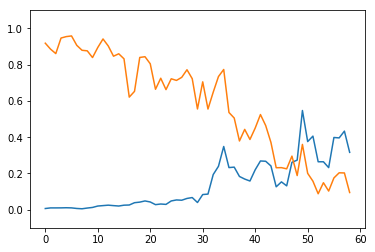

In [131]:
# file = "../detect_result/analyse_fragment/vgg16_basic_multilabel_thresh02/grid/bmx-bumps/000011/obj1/result_11.csv"
# file = "../detect_result/analyse_fragment/vgg16_basic_multilabel_thresh02/grid/mbike-trick/000063/obj0/result_63.csv"
file = "../detect_result/analyse_fragment/vgg16_sigmoid_thresh_multilabel_thresh02/sw/0406/grid/judo/000029/obj1/result_29.csv"

# file = "../detect_result/analyse_fragment/resnet50_std/multi-step_multilabel_thresh02/grid/parkour/000021/obj0/result_21.csv"

left, right = identify_anchor_boundary_wide(file)
print(left)
print(right)
compare_neighboring_anchors(left, right, factor="grid")

frames [3, 20, 35]

0.8798 18 0.7049999999999998
idx 6723
condition1 True
condition2 [ True False]
mean 0.684 / 0.050

0.8858 33 0.69217
idx 6729
condition1 True
condition2 [False  True]
mean 0.104 / 0.766

0.8931 18 0.7251099999999999
idx 6837
condition1 True
condition2 [ True False]
mean 0.695 / 0.039

0.901 33 0.7109099999999999
idx 6843
condition1 True
condition2 [False  True]
mean 0.136 / 0.784

0.899 48 0.70357
idx 6849
condition1 True
condition2 [False  True]
mean 0.125 / 0.127

0.7911 18 0.64729
idx 6951
condition1 True
condition2 [ True False]
mean 0.573 / 0.027

0.8094 34 0.67293
idx 6957
condition1 True
condition2 [False  True]
mean 0.283 / 0.689

0.6862 1 0.5406166666666666
idx 7065
condition1 True
condition2 [False False]
mean 0.226 / 0.010

0.818 13 0.71448
idx 7071
condition1 True
condition2 [ True False]
mean 0.398 / 0.362

0.7741 58 0.6401333333333333
idx 7089
condition1 True
condition2 [False  True]
mean 0.009 / 0.007

{6723: array([19,  5,  8,  5]), 6837: array([19, 

True

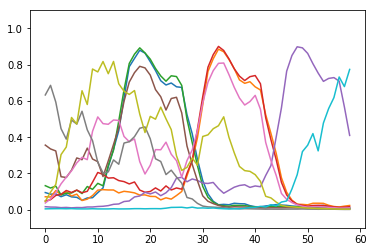

In [174]:
with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
name = "stroller"
obj = 0
frames = [ int(x.split(".")[0]) for x in json_object[name]["obj{}".format(obj)]["image_list"]]
print("frames {}".format(frames))
print()


i = 0
factor = "grid"
file = "../detect_result/analyse_fragment/vgg16_basic_multilabel_thresh02/{}/{}/{}/{}/{}".\
                  format(factor, name, str(frames[i]).zfill(6), "obj{}".format(obj), "result_{}.csv".format(frames[i]))
left, right = identify_anchor_boundary_wide(file)
print(left)
print(right)
compare_neighboring_anchors(left, right, factor="grid")

'../detect_result/analyse_fragment/vgg16_basic_multilabel_thresh02/grid/bike-packing/000026/obj1/result_26.csv'